In [1]:
!pip install torchinfo
!pip install tqdm
!pip install wget

import torch
print(torch.__version__)
from torch import nn
from torch.utils.data import DataLoader

import torchvision
print(torchvision.__version__)
from torchvision import datasets,models,transforms
import torchinfo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from timeit import default_timer as timer
from pathlib import Path
import random,os
import wget,tarfile

import warnings
warnings.simplefilter("ignore", UserWarning)

  Preparing metadata (setup.py) ... - done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=faa952c01d82668d6a8ad8eff3ac29c1818d0208570fb7d16584453d37d4fb91
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
2.1.2
0.16.2


In [2]:
Path('/kaggle/working/results').mkdir(parents=True, exist_ok=True)
Path('/kaggle/working/models').mkdir(parents=True, exist_ok=True)
Path('/kaggle/working/gradio_demo/').mkdir(parents=True, exist_ok=True)

#########################################
# Define Parameters
#########################################
FLAGS = {}
FLAGS['datadir'] = "/kaggle/input/nexum-image-classification/data"
FLAGS['batch_size'] = 8 
FLAGS['num_workers'] = 0
FLAGS['num_epochs'] = 3 #5
FLAGS['show_results_every_X_batch'] = 100
FLAGS['IMAGE_SIZE'] = 224

print (FLAGS)

PATH_results = Path("/kaggle/working/" + "results")
PATH_models = Path("/kaggle/working/" + "models")

device = "cuda" if torch.cuda.is_available() else "cpu"
print (device)

{'datadir': '/kaggle/input/nexum-image-classification/data', 'batch_size': 8, 'num_workers': 0, 'num_epochs': 3, 'show_results_every_X_batch': 100, 'IMAGE_SIZE': 224}
cuda


# Functions

In [3]:
# Define a callback function to display download progress
def progress_bar(current, total, width=80):
    progress = current / total
    bar_length = int(width * progress)
    bar = '=' * bar_length + ' ' * (width - bar_length)

    elapsed_time = time.time() - start_time
    if current > 0:
        remaining_time = elapsed_time * (total / current - 1)
    else:
        remaining_time = 0

    print(f'|{bar}| {progress:.0%} Elapsed: {elapsed_time:.0f}s Remaining: {remaining_time:.0f}s', end='\r')


# Function to extract a member with progress tracking
def extract_member(tar, member, path):
    tar.extract(member, path)  # Extract to the Dataset folder
    global extracted_files
    extracted_files += 1
    progress_bar(extracted_files, total_files)
    
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42,device_=device):
    """Randomly splits a given dataset into two subsets based on split_size and seed.

    Args:
        dataset (torchvision.datasets): A PyTorch Dataset.
        split_size (float): the split size, defaults = 0.2.
        seed (int): Seed for random generator, defaults = 42.

    Returns:
        subset_1, subset_2 (tuple): the two subsets.
    """
    # Create split lengths 
    length_1 = int(len(dataset) * split_size)  # length of subset_1
    length_2 = len(dataset) - length_1 # length of subset_2

    # Print out info
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")

    # Create splits with given random seed
    subset_1, subset_2 = torch.utils.data.random_split(dataset,
                                                       lengths=[length_1, length_2],
                                                       generator=torch.manual_seed(42)
                                                      )
    return subset_1, subset_2


def create_dataloaders(
                        train_dir: str,
                        test_dir: str,
                        transform: transforms.Compose,
                        batch_size: int,
                        num_workers: int=FLAGS['num_workers'],
                        split_size: int=1 # if split_size<1, Create a subset of the dataset
                    ):
    """Creates training and testing DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.
    split_size (float): the split size, default = 1 (no split)

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names) 
    where class_names is a list of the target classes.
  """
    # 1. Create datasets
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)
    print(f"Data size - Train: {len(train_data)} | Test: {len(test_data)}")

    # 2. Get class names
    class_names = train_data.classes

  # 3. Create a subset of the dataset
    if split_size<1:
        train_data, _ = split_dataset(dataset=train_data, split_size=split_size)
        test_data, _ =  split_dataset(dataset=test_data, split_size=split_size)
        print(f"Subset size - Train: {len(train_data)} | Test: {len(test_data)}")

    # 4. Create train and test DataLoaders
    train_dataloader = DataLoader(
                                  train_data,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  # num_workers=num_workers,
                                  # pin_memory=True,
                              )
    test_dataloader = DataLoader(
                                  test_data,
                                  batch_size=batch_size,
                                  shuffle=False,
                                  # num_workers=num_workers,
                                  # pin_memory=True,
                              )
    print(f"Number of batches of the dataloaders - Train: {len(train_dataloader)} | Test: {len(test_dataloader)}")

    return train_dataloader, test_dataloader, class_names

#Create a train step function
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    """Train the model on the dataloader"""
    
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
        # 1. Send data to target device
        X, y = X.to(device), y.to(device)

        # 2. Forward pass
        pred_logits = model(X)
        pred_labels = torch.argmax(torch.softmax(pred_logits, dim=1), dim=1)

        # 3. Calculate and accumulate loss
        loss = loss_fn(pred_logits, y)
        train_loss += loss.item()

        # 4. Calculate and accumulate accuracy 
        acc = accuracy_fn(y,pred_labels)
        train_acc += acc

        # 5. Gradient Descent
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 6. print train loss and accuracy per batch
        if batch % FLAGS['show_results_every_X_batch'] == 0:
            print(f"batch: {batch} | train_loss: {loss.item()} | train_acc: {acc}")

    # 7. Get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

#Create a test loop function
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    """Evaluate the model on the dataloader"""
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # 1. Send data to target device
            X, y = X.to(device), y.to(device)

            # 2. Forward pass
            test_pred_logits = model(X)
            test_pred_labels = test_pred_logits.argmax(dim=1)

            # 3. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # 4. Calculate and accumulate accuracy
            test_acc += accuracy_fn(y,test_pred_labels)

    # 5. Get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

#Combine train and test loop functions
from tqdm.auto import tqdm
def train_and_evaluate(model: torch.nn.Module,
                       train_dataloader: torch.utils.data.DataLoader,
                       test_dataloader: torch.utils.data.DataLoader,
                       epochs: int = 5,
                       learning_rate = 0.001):
    """Train the model for a number of epochs, evaluate the model and track the results."""
    
    # Create empty results dictionary
    results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
      }

    # Set random seeds
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    # Setup loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

    # Start the timer
    from timeit import default_timer as timer
    start_time = timer()

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        print(f"\nepoch: {epoch}\n--------------------------")
        train_loss, train_acc = train_step(model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # Print results per epoch
        print(
            f"Epoch: {epoch} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )        

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    end_time = timer()
    print(f"Total training time: {end_time-start_time:.3f} seconds")

    return results

def get_model_summary(model,input_size=(1,3,FLAGS['IMAGE_SIZE'],FLAGS['IMAGE_SIZE'])):
    """print and return the model summary using torchinfo.summary()"""
    model_summary = torchinfo.summary(model,
                                    input_size=input_size,
                                    col_names=["input_size","output_size","num_params","trainable"],
                                    col_width=15)
    print(model_summary)
    return model_summary

def accuracy_fn(y_true, y_pred):
    """calculate accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels.
        y_pred (torch.Tensor): Predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred.
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def save_model(model,MODEL_SAVE_PATH):
    """Save the model state dict: only saves the learned parameters"""

    print(f"Saving model to: {MODEL_SAVE_PATH}")
    torch.save(obj=model.state_dict(),
                 f=MODEL_SAVE_PATH)

def get_model_stats(model_name,MODEL_SAVE_PATH,model_summary,model_results,avg_prediction_time):
    """return model size in megabytes, number of parameters, test loss/accuray and avg_prediction_time"""

    model_size = np.round(MODEL_SAVE_PATH.stat().st_size / (1024*1024),1)
    num_parameters = model_summary.total_params
    # Create model statistics dictionary
    model_stats = {"model_name":model_name,
                 "test_loss": np.round(model_results["test_loss"][-1],3),
                 "test_acc": np.round(model_results["test_acc"][-1],3),
                 "number_of_parameters": num_parameters,
                 "model_size (MB)": model_size,
                 "avg_prediction_time":avg_prediction_time}
    return model_stats

def save_results_to_CSV(model_results,model_name,split_size,results_save_path):
    model_results_pd = pd.DataFrame(model_results)
    model_results_pd['model_name'] = model_name
    model_results_pd['data'] = split_size
    print(f"Saving results to: {results_save_path}")
    model_results_pd.to_csv(results_save_path,index=False)
    
def compare_results(FeatureExtraction_results, FineTuning_results, 
                    initial_epochs=5,fig_name="fig",save_fig=False,
                    PATH_results=PATH_results,suptitle=""):
    """
    Returns two plots: Accuracy and Loss. Compares the results of the feature extractor and after fine tuning.
    
    Args:
      FeatureExtraction_results: results of the feature extractor.
      FineTuning_results: results after fine tuning.
      initial_epochs: Number of epochs of the feature extractor.
      fig_name: Name of the figure
      save_fig (boolean): if True, save the figure. 
      suptitle (str): suptitle
    """
    
    # Get Feature Extraction results
    acc = FeatureExtraction_results["train_acc"]
    loss = FeatureExtraction_results["train_loss"]

    val_acc = FeatureExtraction_results["test_acc"]
    val_loss = FeatureExtraction_results["test_loss"]

    # Combine Feature Extraction results with Fine tuning results
    total_acc = acc + FineTuning_results["train_acc"]
    total_loss = loss + FineTuning_results["train_loss"]

    total_val_acc = val_acc + FineTuning_results["test_acc"]
    total_val_loss = val_loss + FineTuning_results["test_loss"]

    # Plot loss curves
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(total_acc, label='train_acc')
    plt.plot(total_val_acc, label='test_acc')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.ylabel("%")
    plt.title('Training and test Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(total_loss, label='train_loss')
    plt.plot(total_val_loss, label='test_loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and test Loss')
    plt.xlabel('epoch')

    if suptitle!="":
        plt.suptitle(suptitle, fontsize=18)
    
    
    if save_fig:
        fig_name = fig_name+".jpg"
        plt.savefig(PATH_results / fig_name)

    plt.show()
    
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_timing(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    print("\nMake predictions and calculate average prediction time...")

    pred_list = [] # list to store prediction dictionaires

    for path in tqdm(paths):

        pred_dict = {} # dict to store prediction information (path, class_name, pred_prob, pred_class and time_for_pred) 

        # Set path and class_name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        start_time = timer() # 5. Start the prediction timer

        # Open image path
        img = Image.open(path)

        # Transform the image and add batch dimension
        transformed_image = transform(img).unsqueeze(0).to(device)

        # Prepare model for inference
        model.to(device)
        model.eval()

        # Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # prediction logits
            pred_prob = torch.softmax(pred_logit, dim=1) # prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # prediction labels
            pred_class = class_names[pred_label.cpu()] 

            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # Calculate prediction time
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # Was the prediction right?
        pred_dict["correct"] = class_name == pred_class

        # Add the dict to the list of preds 
        pred_list.append(pred_dict)

        # Convert to dataframe
        pred_df = pd.DataFrame(pred_list)

        # Calculate average prediction time
        avg_prediction_time = round(pred_df.time_for_pred.mean(), 4)

    return pred_list,pred_df,avg_prediction_time

def plot_loss_curves(results,graph_name="fig",save_graph=False,
                     PATH_results=PATH_results,suptitle=""):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g. {"train_loss": [...], "train_acc": [...],...}
        graph_name (str): the name of the graph
        save_graph (boolean): if True, the graph will be saved
        PATH_results: the path where the graph will be stored
        suptitle (str): add a suptitle, default None
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    if suptitle!="":
        plt.suptitle(suptitle, fontsize=18)
    
    # Save the figure
    if save_graph:
        graph_name = graph_name+".jpg"
        plt.savefig(PATH_results / graph_name)
        
class TinyVGG(nn.Module):
    """
    Model architecture replicating TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*56*56, # 56 = 224/4 where 224 is the image size
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

def create_effnetb2_model(num_classes:int=10,
                          seed:int=42,
                          is_TrivialAugmentWide = True,
                          freeze_layers=True):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int): number of classes in the classifier head, default = 10
        seed (int): random seed value, default = 42
        is_TrivialAugmentWide (boolean): Artificially increase the diversity of a training dataset with data augmentation, default = True.

    Returns:
        effnetb2_model (torch.nn.Module): EfficientNet_B2 model.
        effnetb2_transforms (torchvision.transforms): EfficientNet_B2 image transforms.
    """
    # 1. Create EfficientNet_B2 pretrained weights and transforms
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    effnetb2_transforms = weights.transforms()

    if is_TrivialAugmentWide:
        effnetb2_transforms = torchvision.transforms.Compose([
                  torchvision.transforms.TrivialAugmentWide(num_magnitude_bins=8),
                  effnetb2_transforms,
      ])

    # 2. Create the EfficientNet_B2 model
    effnetb2_model = torchvision.models.efficientnet_b2(weights=weights)

    # 3. Freeze all layers of the model
    if freeze_layers:
        for param in effnetb2_model.parameters():
            param.requires_grad = False

    # 4. Change classifier head 
    torch.manual_seed(seed)
    effnetb2_model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return effnetb2_model, effnetb2_transforms

There are 2 directories and 0 images in '/kaggle/input/nexum-image-classification/data'.
There are 9 directories and 0 images in '/kaggle/input/nexum-image-classification/data/test'.
There are 0 directories and 495 images in '/kaggle/input/nexum-image-classification/data/test/CreazioneDiAdamo-Pannello3'.
There are 0 directories and 501 images in '/kaggle/input/nexum-image-classification/data/test/CreazioneDiAdamo-Pannello4'.
There are 0 directories and 495 images in '/kaggle/input/nexum-image-classification/data/test/CreazioneDiAdamo-Pannello1'.
There are 0 directories and 495 images in '/kaggle/input/nexum-image-classification/data/test/BasilicaDiSanPietro'.
There are 0 directories and 534 images in '/kaggle/input/nexum-image-classification/data/test/CreazioneDiEva-Pannello4'.
There are 0 directories and 513 images in '/kaggle/input/nexum-image-classification/data/test/CreazioneDiEva-Pannello2'.
There are 0 directories and 537 images in '/kaggle/input/nexum-image-classification/data/t

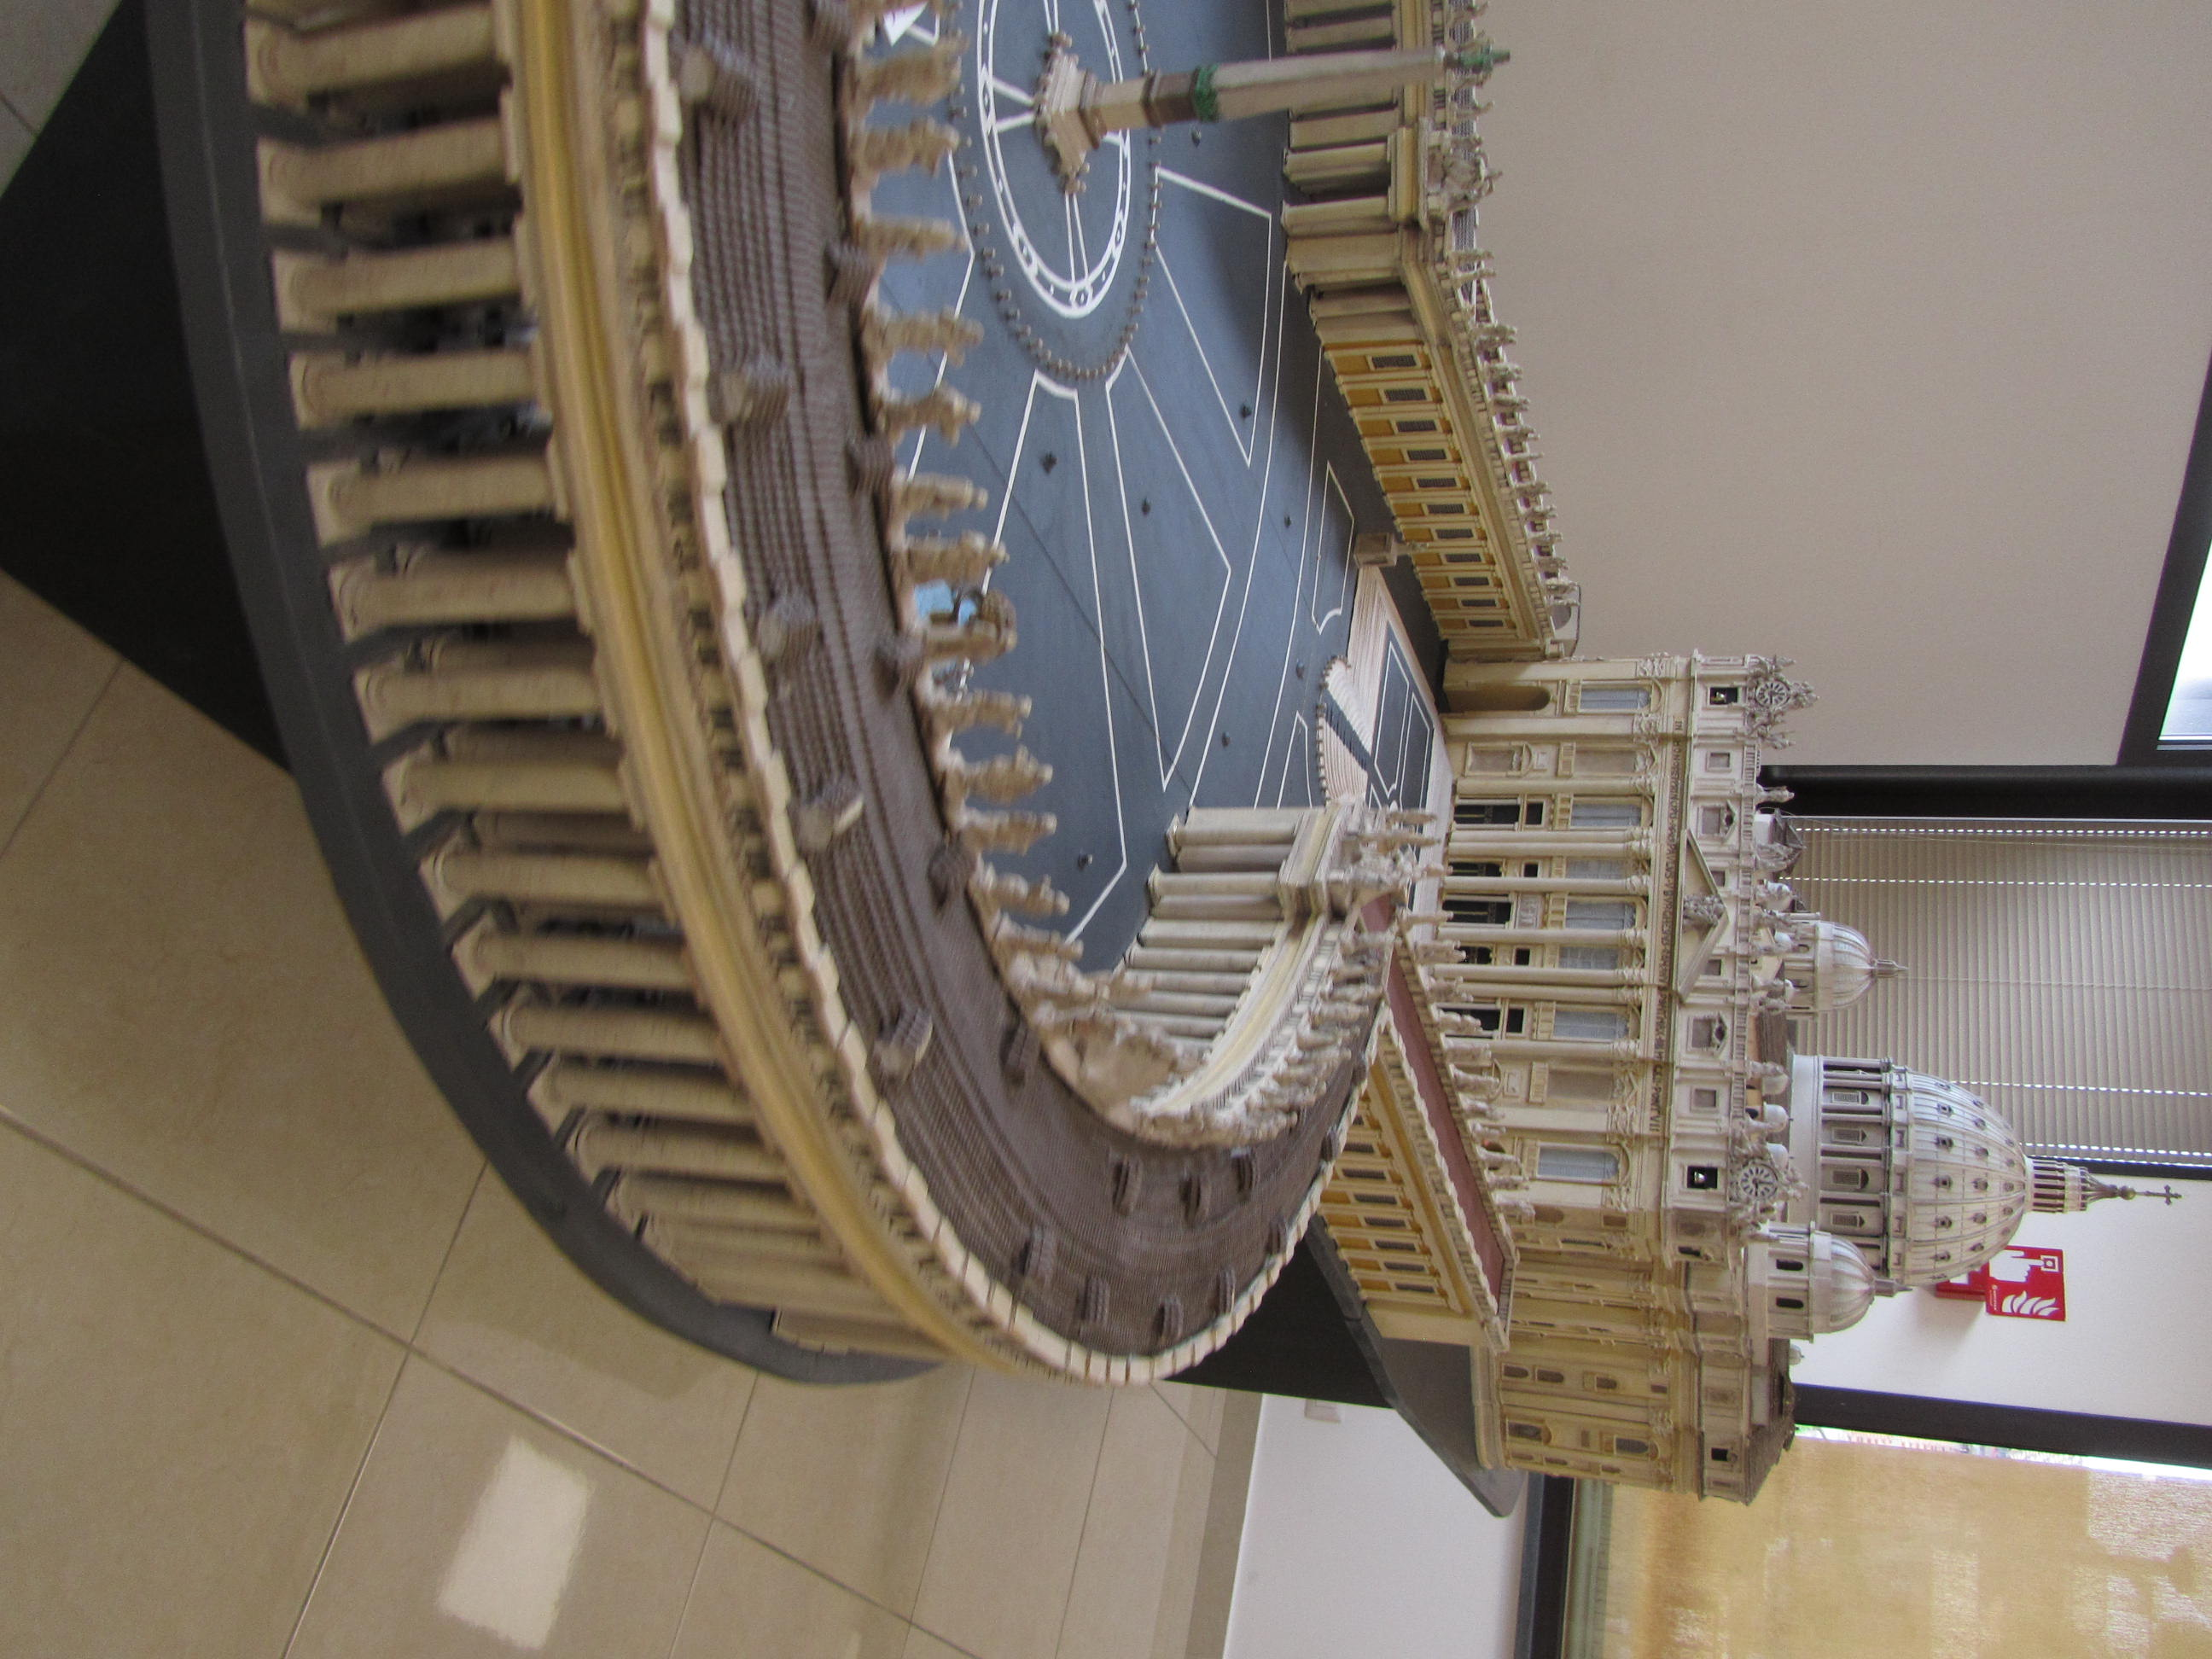

In [4]:
data_path = Path(FLAGS['datadir'])
image_path = data_path / ""

for dirpath, dirnames, filenames in os.walk(image_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
# 1. Get image paths 
image_path_list = list(image_path.glob('train/BasilicaDiSanPietro/*.JPG'))
# 2. Get random image path
random_image_path = random.choice(image_path_list)
# 3. Get image class from path name
image_class = random_image_path.parent.stem
# 4. Open image
img = Image.open(random_image_path)
# 5. Print Image class, heigt and width
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

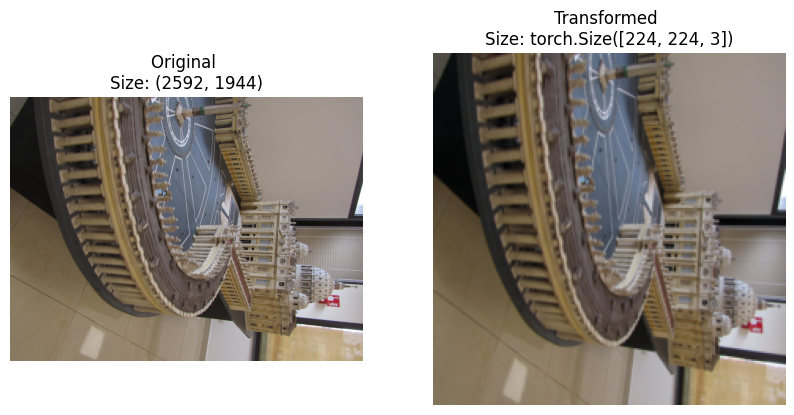

In [5]:
data_transform = transforms.Compose([
transforms.Resize(size=(FLAGS['IMAGE_SIZE'], FLAGS['IMAGE_SIZE'])),
transforms.TrivialAugmentWide(num_magnitude_bins=8), # Data Augmentation
transforms.ToTensor()
])
with Image.open(random_image_path) as f:
    fig, ax = plt.subplots(1, 2,figsize=(10,7))
    ax[0].imshow(f)
    ax[0].set_title(f"Original \nSize: {f.size}")
    ax[0].axis("off")

    # Transform and plot image
    transformed_image = data_transform(f).permute(1, 2, 0)
    ax[1].imshow(transformed_image)
    ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
    ax[1].axis("off")

# Convolutional model - EfficientNet_B2: Feature Extraction

In [6]:
# Create a feature extractor by freezing all the layers of the EfficientNet_B2 model
model_EfficientNet_B2,effnetb2_transforms = create_effnetb2_model(num_classes=9,
                                                                  is_TrivialAugmentWide = True,
                                                                  freeze_layers=False)
# Print a summary using torchinfo
summary_EfficientNet_B2 = get_model_summary(model_EfficientNet_B2)
# Feature extraction on 20% of the data with data augmentation
train_DataLoader,test_DataLoader,class_names = create_dataloaders(train_dir=image_path / "train",
                                                                  test_dir=image_path / "test",
                                                                  transform=effnetb2_transforms,
                                                                  batch_size=FLAGS['batch_size'],
                                                                  split_size=0.2)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 117MB/s]


Layer (type:depth-idx)                                  Input Shape     Output Shape    Param #         Trainable
EfficientNet                                            [1, 3, 224, 224] [1, 9]          --              True
├─Sequential: 1-1                                       [1, 3, 224, 224] [1, 1408, 7, 7] --              True
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224] [1, 32, 112, 112] --              True
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224] [1, 32, 112, 112] 864             True
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112] [1, 32, 112, 112] 64              True
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112] [1, 32, 112, 112] --              --
│    └─Sequential: 2-2                                  [1, 32, 112, 112] [1, 16, 112, 112] --              True
│    │    └─MBConv: 3-4                                 [1, 32, 112, 112] [1, 16, 112, 112] 1,448        

In [7]:
# Get all test data paths
test_dir = image_path / "test"
test_data_paths = list(Path(test_dir).glob("*/*.JPG"))

# Get 200 random images 
random_image_paths = random.sample(test_data_paths,200)
print(f"[INFO] Random selection of 200 images from {test_dir}")

[INFO] Random selection of 200 images from /kaggle/input/nexum-image-classification/data/test


  0%|          | 0/3 [00:00<?, ?it/s]


epoch: 0
--------------------------
batch: 0 | train_loss: 2.074565887451172 | train_acc: 25.0
batch: 100 | train_loss: 1.2174612283706665 | train_acc: 75.0
batch: 200 | train_loss: 0.9918329119682312 | train_acc: 62.5
Epoch: 0 | train_loss: 1.2752 | train_acc: 53.6667 | test_loss: 1.0510 | test_acc: 62.7536

epoch: 1
--------------------------
batch: 0 | train_loss: 1.4688042402267456 | train_acc: 62.5
batch: 100 | train_loss: 1.980372428894043 | train_acc: 37.5
batch: 200 | train_loss: 0.7406034469604492 | train_acc: 50.0
Epoch: 1 | train_loss: 0.9381 | train_acc: 67.8333 | test_loss: 0.7373 | test_acc: 74.2391

epoch: 2
--------------------------
batch: 0 | train_loss: 0.7450813055038452 | train_acc: 75.0
batch: 100 | train_loss: 0.8366546630859375 | train_acc: 62.5
batch: 200 | train_loss: 0.45436573028564453 | train_acc: 87.5
Epoch: 2 | train_loss: 0.7986 | train_acc: 71.8333 | test_loss: 0.6684 | test_acc: 76.0145
Total training time: 736.633 seconds
Saving results to: /kaggle/w

  0%|          | 0/200 [00:00<?, ?it/s]

EfficientNet_avg_prediction_time: 0.1665

stats_EfficientNet_20percent:


{'model_name': 'EfficientNet_B2',
 'test_loss': 0.668,
 'test_acc': 76.014,
 'number_of_parameters': 7713675,
 'model_size (MB)': 29.9,
 'avg_prediction_time': 0.1665}

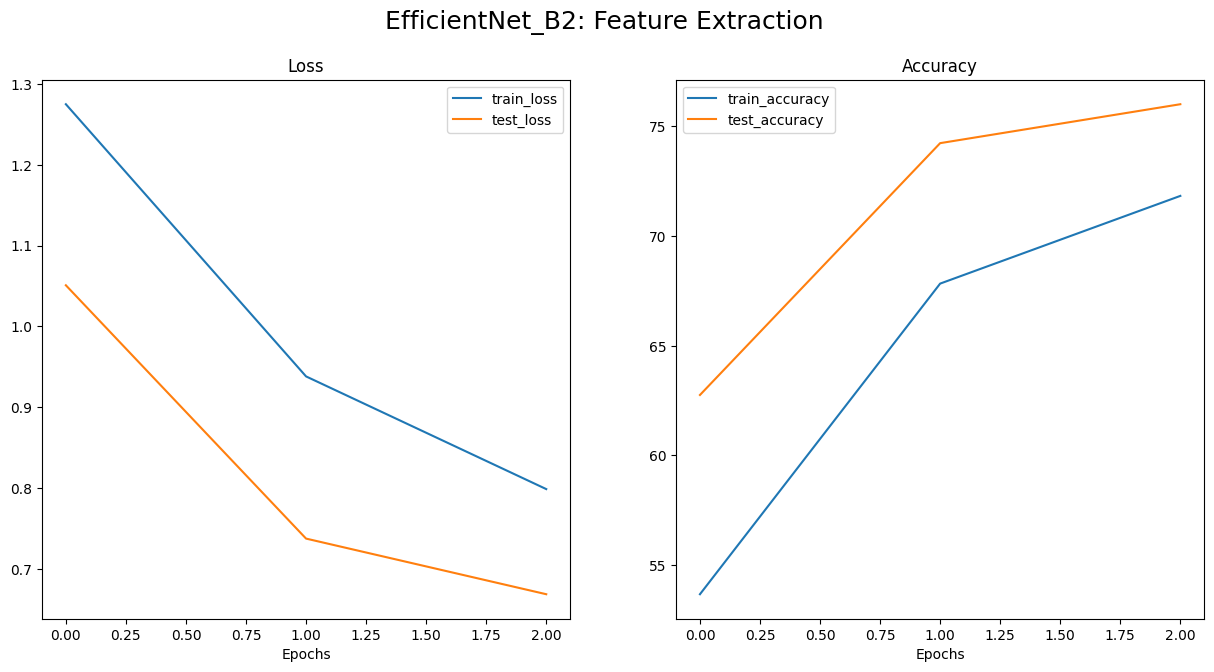

In [8]:
# 1. train and evaluate the model
results_EfficientNet_B2_20percent = train_and_evaluate(model=model_EfficientNet_B2,
                                                       train_dataloader=train_DataLoader,
                                                       test_dataloader=test_DataLoader,
                                                       epochs=FLAGS['num_epochs'],
                                                       learning_rate=0.001)

# 2. Save results
save_results_to_CSV(model_results=results_EfficientNet_B2_20percent,
                    model_name = "EfficientNet_B2",
                    split_size = 0.2,
                    results_save_path = PATH_results / "results_EfficientNet_B2_20percent.csv")

# 3. Plot loss curves
plot_loss_curves(results_EfficientNet_B2_20percent,
                 graph_name="fig_EfficientNet_B2_20percent",
                 save_graph=True,suptitle="EfficientNet_B2: Feature Extraction")

# 4. Save the model
save_model(model = model_EfficientNet_B2,
           MODEL_SAVE_PATH = PATH_models / "EfficientNet_B2_20percent.pth"
           )

# 5. Make predictions and calculate avg prediction time 
EfficientNet_test_pred_dicts,EfficientNet_test_pred_df,EfficientNet_avg_prediction_time =\
pred_and_timing(paths=random_image_paths,
                model=model_EfficientNet_B2,
                transform=effnetb2_transforms,
                class_names=class_names,
                device="cpu") # make predictions on CPU

print("EfficientNet_avg_prediction_time:",EfficientNet_avg_prediction_time)

# 6. Collect model stats
stats_EfficientNet_20percent = get_model_stats(model_name = "EfficientNet_B2",
                                               MODEL_SAVE_PATH = PATH_models / "EfficientNet_B2_20percent.pth",
                                               model_summary= summary_EfficientNet_B2,
                                               model_results = results_EfficientNet_B2_20percent,
                                               avg_prediction_time= EfficientNet_avg_prediction_time
                                               )
# 7. Save the stats to csv
pd.DataFrame([stats_EfficientNet_20percent]).to_csv(PATH_results / "stats_EfficientNet_20percent.csv",index=False)
print("\nstats_EfficientNet_20percent:")
stats_EfficientNet_20percent

Layer (type:depth-idx)                                  Input Shape     Output Shape    Param #         Trainable
EfficientNet                                            [1, 3, 224, 224] [1, 9]          --              True
├─Sequential: 1-1                                       [1, 3, 224, 224] [1, 1408, 7, 7] --              True
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224] [1, 32, 112, 112] --              True
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224] [1, 32, 112, 112] 864             True
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112] [1, 32, 112, 112] 64              True
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112] [1, 32, 112, 112] --              --
│    └─Sequential: 2-2                                  [1, 32, 112, 112] [1, 16, 112, 112] --              True
│    │    └─MBConv: 3-4                                 [1, 32, 112, 112] [1, 16, 112, 112] 1,448        

  0%|          | 0/3 [00:00<?, ?it/s]


epoch: 0
--------------------------
batch: 0 | train_loss: 1.2305454015731812 | train_acc: 62.5
batch: 100 | train_loss: 0.5567273497581482 | train_acc: 87.5
batch: 200 | train_loss: 0.31361955404281616 | train_acc: 87.5
batch: 300 | train_loss: 0.2857652008533478 | train_acc: 100.0
batch: 400 | train_loss: 0.12334547936916351 | train_acc: 100.0
batch: 500 | train_loss: 0.7587426900863647 | train_acc: 87.5
batch: 600 | train_loss: 0.016503095626831055 | train_acc: 100.0
batch: 700 | train_loss: 0.07796161621809006 | train_acc: 100.0
batch: 800 | train_loss: 0.0848807841539383 | train_acc: 100.0
batch: 900 | train_loss: 0.39984646439552307 | train_acc: 87.5
batch: 1000 | train_loss: 0.11323411017656326 | train_acc: 100.0
batch: 1100 | train_loss: 0.004144539590924978 | train_acc: 100.0
Epoch: 0 | train_loss: 0.2956 | train_acc: 90.1778 | test_loss: 0.1008 | test_acc: 96.7220

epoch: 1
--------------------------
batch: 0 | train_loss: 0.14788281917572021 | train_acc: 87.5
batch: 100 | t

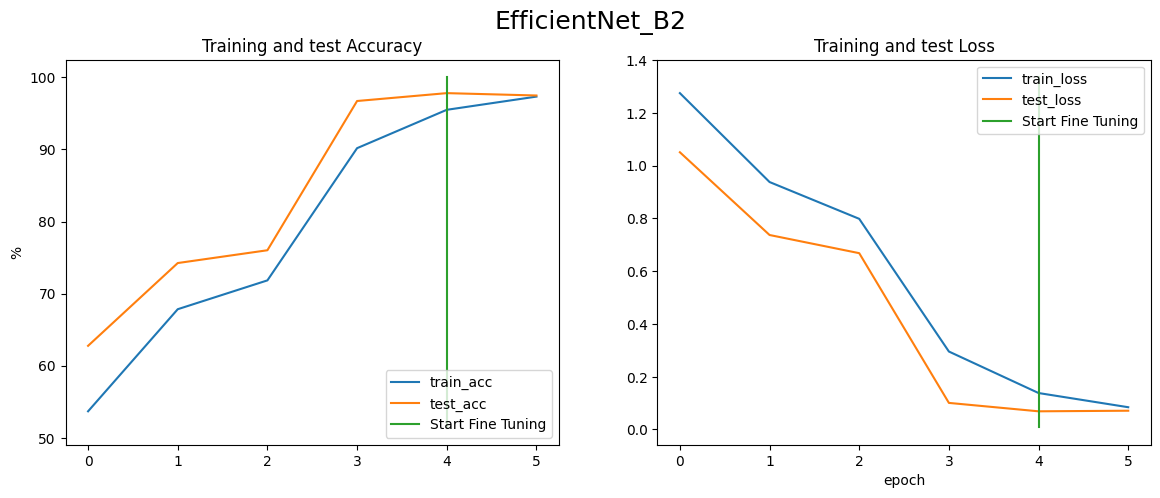

Saving model to: /kaggle/working/models/EfficientNet_B2_FT.pth

Make predictions and calculate average prediction time...


  0%|          | 0/200 [00:00<?, ?it/s]

EfficientNet_avg_prediction_time: 0.1316
\stats_EfficientNet_FT:


{'model_name': 'EfficientNet_B2',
 'test_loss': 0.071,
 'test_acc': 97.487,
 'number_of_parameters': 7713675,
 'model_size (MB)': 29.9,
 'avg_prediction_time': 0.1316}

In [9]:
# Create a new instance of EfficientNet_B2 with all its layers trainable.
model_EfficientNet_B2,effnetb2_transforms = create_effnetb2_model(num_classes=9,
                                                                  is_TrivialAugmentWide = False,
                                                                  freeze_layers=False)

# Print a summary using torchinfo
summary_EfficientNet_B2 = get_model_summary(model_EfficientNet_B2)

# Load the state_dict of our saved feature extractor model 
# this will update the new instance of our model with trained weights)

MODEL_SAVE_PATH = PATH_models / "EfficientNet_B2_20percent.pth"
# MODEL_SAVE_PATH = "/kaggle/input/efficientnet-b2/EfficientNet_B2_20percent.pth"
model_EfficientNet_B2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Create dataloaders using EfficientNet_B2 transforms
train_DataLoader,test_DataLoader,class_names = create_dataloaders(train_dir=image_path / "train",
                                                                  test_dir=image_path / "test",
                                                                  transform=effnetb2_transforms,
                                                                  batch_size=FLAGS['batch_size'],
                                                                  split_size=1)

# 1. train and evaluate the model
results_EfficientNet_B2_FT = train_and_evaluate(model=model_EfficientNet_B2,
                                                train_dataloader=train_DataLoader,
                                                test_dataloader=test_DataLoader,
                                                epochs=FLAGS['num_epochs'],
                                                learning_rate=0.0001)

# 2. Save results
save_results_to_CSV(model_results=results_EfficientNet_B2_FT,
                    model_name = "EfficientNet_B2",
                    split_size = 1,
                    results_save_path = PATH_results / "results_EfficientNet_B2_FT.csv")

# 3. Plot loss curves - Compare Feature extraction vs. Fine tuning
results_EfficientNet_B2_20percent = pd.read_csv(PATH_results / "results_EfficientNet_B2_20percent.csv").to_dict(orient='list')
results_EfficientNet_B2_FT = pd.read_csv(PATH_results / "results_EfficientNet_B2_FT.csv").to_dict(orient='list')

compare_results(results_EfficientNet_B2_20percent,results_EfficientNet_B2_FT,
                initial_epochs=5,
                fig_name="fig_EfficientNet_B2_FT",save_fig=True,
                suptitle="EfficientNet_B2")

# 4. Save the model
save_model(model = model_EfficientNet_B2,
           MODEL_SAVE_PATH = PATH_models / "EfficientNet_B2_FT.pth"
           )

# 5. Make predictions and calculate avg prediction time
EfficientNet_test_pred_dicts,EfficientNet_test_pred_df,EfficientNet_avg_prediction_time =\
pred_and_timing(paths=random_image_paths,
                model=model_EfficientNet_B2,
                transform=effnetb2_transforms,
                class_names=class_names,
                device="cpu") # make predictions on CPU

print("EfficientNet_avg_prediction_time:",EfficientNet_avg_prediction_time)

# 6. Collect model stats
stats_EfficientNet_FT = get_model_stats(model_name = "EfficientNet_B2",
                                        MODEL_SAVE_PATH = PATH_models / "EfficientNet_B2_FT.pth",
                                        model_summary= summary_EfficientNet_B2,
                                        model_results = results_EfficientNet_B2_FT,
                                        avg_prediction_time= EfficientNet_avg_prediction_time
                                        )
# 7. Save the stats to csv
pd.DataFrame([stats_EfficientNet_FT]).to_csv(PATH_results / "stats_EfficientNet_FT.csv",index=False)
print("\stats_EfficientNet_FT:")
stats_EfficientNet_FT

Making predictions:   0%|          | 0/572 [00:00<?, ?it/s]

                            precision    recall  f1-score   support

       BasilicaDiSanPietro       1.00      1.00      1.00       495
CreazioneDiAdamo-Pannello1       0.98      0.99      0.98       495
CreazioneDiAdamo-Pannello2       0.98      0.97      0.97       495
CreazioneDiAdamo-Pannello3       0.98      0.97      0.98       495
CreazioneDiAdamo-Pannello4       0.98      0.98      0.98       501
  CreazioneDiEva-Pannello1       0.99      0.98      0.98       510
  CreazioneDiEva-Pannello2       0.98      0.96      0.97       513
  CreazioneDiEva-Pannello3       0.95      0.95      0.95       537
  CreazioneDiEva-Pannello4       0.95      0.98      0.96       534

                  accuracy                           0.97      4575
                 macro avg       0.98      0.98      0.98      4575
              weighted avg       0.97      0.97      0.97      4575



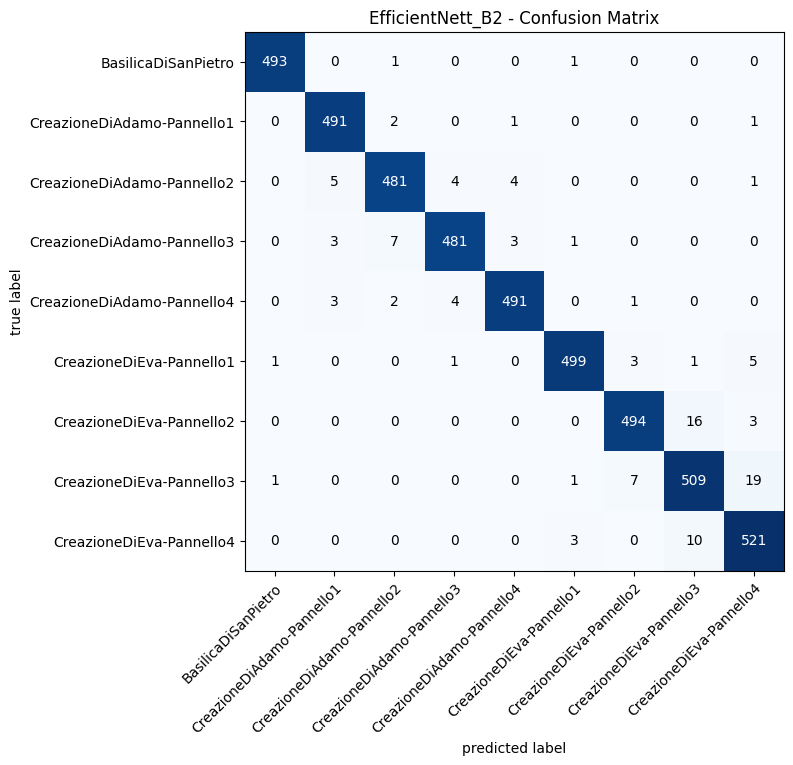

In [10]:
# 1. Get target labels
test_data = datasets.ImageFolder(image_path / "test",
                                 transform=effnetb2_transforms)
targets = test_data.targets


# 2. Make predictions
y_preds = []
model_EfficientNet_B2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_DataLoader, desc="Making predictions"):
        X, y = X.to(device), y.to(device)    
        y_logit = model_EfficientNet_B2.to(device)(X) # forward pass
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # pred labels
        y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

# 3. Setup confusion matrix 
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

cm = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
cm_tensor = cm(preds=y_pred_tensor,
               target=torch.tensor(test_data.targets))

# 4. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=cm_tensor.numpy(), 
    class_names=class_names, 
    figsize=(10, 7)
)
ax.set(title="EfficientNett_B2 - Confusion Matrix");
fig.savefig(PATH_results / "fig_effNet_confusionMatrix.jpg")

# Classification report

from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(test_data.targets,y_pred_tensor.numpy(),target_names=class_names))

In [11]:
#Fine Tuning
EfficientNet_test_pred_dicts,EfficientNet_test_pred_df,EfficientNet_avg_prediction_time =\
pred_and_timing(paths=random_image_paths,
                model=model_EfficientNet_B2,
                transform=effnetb2_transforms,
                class_names=class_names,
                device="cpu") # make predictions on CPU

print("EfficientNet_avg_prediction_time:",EfficientNet_avg_prediction_time)
EfficientNet_test_pred_df[:5]


Make predictions and calculate average prediction time...


  0%|          | 0/200 [00:00<?, ?it/s]

EfficientNet_avg_prediction_time: 0.13


image_path  \
0  /kaggle/input/nexum-image-classification/data/...   
1  /kaggle/input/nexum-image-classification/data/...   
2  /kaggle/input/nexum-image-classification/data/...   
3  /kaggle/input/nexum-image-classification/data/...   
4  /kaggle/input/nexum-image-classification/data/...   

                 class_name  pred_prob                pred_class  \
0  CreazioneDiEva-Pannello3     0.9999  CreazioneDiEva-Pannello3   
1  CreazioneDiEva-Pannello4     0.9963  CreazioneDiEva-Pannello4   
2  CreazioneDiEva-Pannello1     0.9986  CreazioneDiEva-Pannello1   
3  CreazioneDiEva-Pannello2     0.9998  CreazioneDiEva-Pannello2   
4  CreazioneDiEva-Pannello1     0.9998  CreazioneDiEva-Pannello1   

   time_for_pred  correct  
0         0.1852     True  
1         0.1145     True  
2         0.1174     True  
3         0.1463     True  
4         0.1165     True